# IMDB Sentiment Analysis with TensorFlow

### Core Machine Learning
*   **`tensorflow as tf`**: This is the fundamental library for the entire project. TensorFlow provides the tools to build, train, and deploy machine learning models, especially neural networks.
*   **`tensorflow.keras.layers`**: Keras is TensorFlow's user-friendly API for building neural networks. The `layers` module provides the building blocks for your model, such as `Embedding` (to convert words into numerical vectors), `Dense` (standard neural network layers), and `Dropout` (to prevent overfitting).
*   **`tensorflow.keras.losses`**: This provides the loss functions, which are used to measure how inaccurate the model's predictions are. The goal of training is to minimize this value. The tutorial uses `BinaryCrossentropy` for a two-class problem (positive/negative).

### Data Handling and Preparation
*   **`numpy as np`**: A core library for numerical operations. TensorFlow is tightly integrated with NumPy, and it's often used to handle the numerical data (vectors and matrices) that the model processes.
*   **`pandas as pd`**: While not used in the first cell of your notebook, Pandas is essential for reading, writing, and manipulating structured data, such as from a CSV file. You would typically use it to load your dataset into a structure called a DataFrame.
*   **`os`**: This module helps interact with the operating system, primarily for handling file paths and directories. The tutorial uses it to manage the dataset files after they are downloaded.
*   **`shutil`**: Provides high-level file operations. The tutorial uses it to remove the downloaded dataset directory to clean up the workspace.

### Text Processing
*   **`re`**: The regular expression module. It's crucial for cleaning text data. In the tutorial, it's used to remove HTML tags like `<br />` from the movie reviews.
*   **`string`**: This module contains common string constants. The tutorial uses `string.punctuation` to easily access a list of all punctuation marks that should be stripped from the text.

### Data Visualization
*   **`matplotlib.pyplot as plt`**: The primary library for creating plots and graphs. It's used at the end of the tutorial to visualize the model's training and validation accuracy and loss over time. This helps you understand if the model is learning effectively or overfitting.
*   **`seaborn as sns`**: Built on top of Matplotlib, Seaborn provides more advanced and aesthetically pleasing statistical plots. While not strictly required by the tutorial, it's often used for tasks like creating confusion matrices or visualizing data distributions.

In [1]:
# This cell imports all the necessary libraries.
# tensorflow: The core machine learning framework.
# keras: A high-level API to build and train models in TensorFlow.
# matplotlib/seaborn: For plotting and data visualization.
# numpy/pandas: For numerical operations and data handling.
# os/shutil/re/string: For file operations and text processing.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
import re
import shutil
import string
import tensorflow as tf
import keras

from keras import layers
from keras import losses

print(tf.__version__)


2.20.0


In [2]:
# This cell downloads the IMDb movie review dataset from a Stanford URL.
# tf.keras.utils.get_file is a handy utility that downloads a file, caches it,
# and in this case, untars it (since untar=True) to a specified directory.
# Download and explore the IMDB dataset

# 1. Get the data from the web
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')



In [3]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb_v1')

In [4]:
os.listdir(dataset_dir)

['aclImdb']

In [5]:
train_dir = os.path.join(dataset_dir, 'aclImdb', 'train')
test_dir = os.path.join(dataset_dir, 'aclImdb', 'test')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [10]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [13]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
     

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [15]:
# Make a text-only dataset (without labels), then call adapt

print("Starting to adapt the vectorize_layer...")

vectorize_layer.adapt(raw_train_ds.map(lambda text, label: text))

#train_text = raw_train_ds.map(lambda x, y: x)
#vectorize_layer.adapt(train_text)

print("Adaptation complete.")

Starting to adapt the vectorize_layer...
Adaptation complete.


In [16]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [17]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [18]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [19]:
vocab = vectorize_layer.get_vocabulary()

max_index = len(vocab) - 1
print(f"Total vocabulary size: {len(vocab)}")
print(f"Maximum index: {max_index}")

Total vocabulary size: 10000
Maximum index: 9999


In [20]:
#show the first 20 words in the vocabulary
print(f"First 20 words in the vocabulary:\n {vocab[:20]}")

First 20 words in the vocabulary:
 ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('a'), np.str_('of'), np.str_('to'), np.str_('is'), np.str_('in'), np.str_('it'), np.str_('i'), np.str_('this'), np.str_('that'), np.str_('was'), np.str_('as'), np.str_('for'), np.str_('with'), np.str_('movie'), np.str_('but'), np.str_('film')]


In [21]:
#show the last 20 words in the vocabulary
print(f"Last 20 words in the vocabulary:\n {vocab[-20:]}")

Last 20 words in the vocabulary:
 [np.str_('sophomoric'), np.str_('soooo'), np.str_('smoothly'), np.str_('smarmy'), np.str_('slut'), np.str_('skimpy'), np.str_('skeleton'), np.str_('singin'), np.str_('shudder'), np.str_('shoestring'), np.str_('sherry'), np.str_('sheila'), np.str_('shawshank'), np.str_('shamelessly'), np.str_('seinfeld'), np.str_('segal'), np.str_('scenic'), np.str_('sarne'), np.str_('sabu'), np.str_('rushes')]


In [22]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
embedding_dim = 16

In [25]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [27]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - binary_accuracy: 0.6366 - loss: 0.6645 - val_binary_accuracy: 0.7264 - val_loss: 0.6142
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7770 - loss: 0.5497 - val_binary_accuracy: 0.8136 - val_loss: 0.4976
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8299 - loss: 0.4475 - val_binary_accuracy: 0.8326 - val_loss: 0.4268
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8560 - loss: 0.3841 - val_binary_accuracy: 0.8412 - val_loss: 0.3865
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8697 - loss: 0.3427 - val_binary_accuracy: 0.8446 - val_loss: 0.3634
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8813 - loss: 0.3123 - val_binary_accuracy: 0.8514 - val_loss: 0.3459
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8896 - loss: 0.2886 - val_binary_accuracy: 0.8568 - val_loss: 0.3313
Epoch

In [28]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8534 - loss: 0.3345
Loss:  0.3345191776752472
Accuracy:  0.8533599972724915


In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

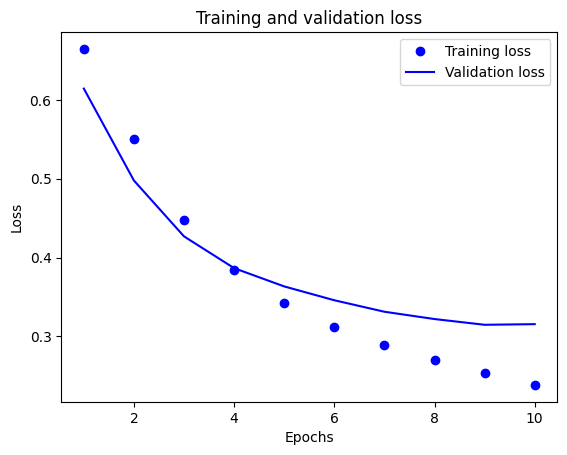

In [30]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

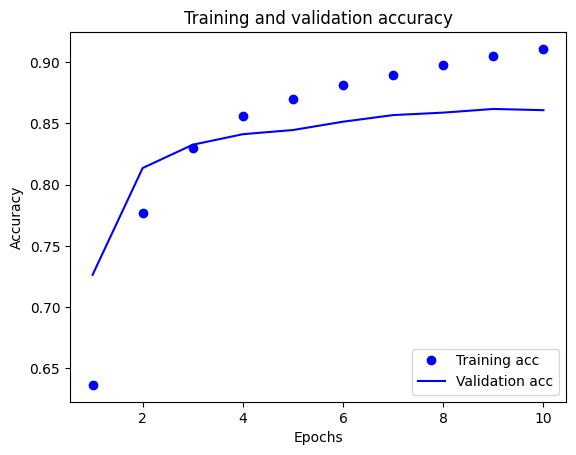

In [31]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()
     

In [32]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5000 - loss: 0.5884
{'accuracy': 0.5000399947166443, 'loss': 0.588399350643158}


In [33]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


array([[0.57856363],
       [0.5449687 ],
       [0.5323437 ]], dtype=float32)